# Momentum Trading Strategy

This notebook explores the fundamentals of momentum trading, a strategy that focuses on capitalizing on the continuation of price trends. We'll cover how to identify momentum, set up entry and exit points, and use Python to backtest momentum trading strategies. Key technical indicators like Moving Averages and Relative Strength Index (RSI) will be used to assess and apply this strategy. This is ideal for active traders looking to make informed trades by identifying strong price movements within shorter timeframes. For a detailed explanation, check out the full article on Medium here.

## Import Required Libraries

In [749]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from tabulate import tabulate
import numpy as np

## Fetch Data

We now use the yfinance library to fetch data for our stock of interest

In [763]:
# Define the stock symbol and the date range for our data
stock_symbol = 'TSLA'
start_date = '2024-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')  # Sets end date to today's date
print(f"Momentum Trading for: {stock_symbol}\nStart Date: {start_date}\nEnd Date: {end_date}")

Momentum Trading for: TSLA
Start Date: 2024-01-01
End Date: 2024-11-12


In [751]:
df = yf.download(stock_symbol, start=start_date, end=end_date)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2024-01-02 00:00:00+00:00,248.419998,248.419998,251.250000,244.410004,250.080002,104654200
2024-01-03 00:00:00+00:00,238.449997,238.449997,245.679993,236.320007,244.979996,121082600
2024-01-04 00:00:00+00:00,237.929993,237.929993,242.699997,237.729996,239.250000,102629300
2024-01-05 00:00:00+00:00,237.490005,237.490005,240.119995,234.899994,236.860001,92379400
2024-01-08 00:00:00+00:00,240.449997,240.449997,241.250000,235.300003,236.139999,85166600


### Preprocess Data

In [752]:
# Select the desired columns (first level of MultiIndex)
df.columns = df.columns.get_level_values(0)

# Keep only the columns you are interested in
df = df[['Open', 'Close', 'Volume', 'Low', 'High']]

# If the index already contains the dates, rename the index
df.index.name = 'Date'  # Ensure the index is named "Date"
    
# Resetting the index if necessary
df.reset_index(inplace=True)

# Ensure that the index is of type datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index again (in case it's reset)
df.set_index('Date', inplace=True)

df.head()

Price,Open,Close,Volume,Low,High
Date,,,,,
2024-01-02 00:00:00+00:00,250.080002,248.419998,104654200,244.410004,251.250000
2024-01-03 00:00:00+00:00,244.979996,238.449997,121082600,236.320007,245.679993
2024-01-04 00:00:00+00:00,239.250000,237.929993,102629300,237.729996,242.699997
2024-01-05 00:00:00+00:00,236.860001,237.490005,92379400,234.899994,240.119995
2024-01-08 00:00:00+00:00,236.139999,240.449997,85166600,235.300003,241.250000


### Visualize Stock Chart Data

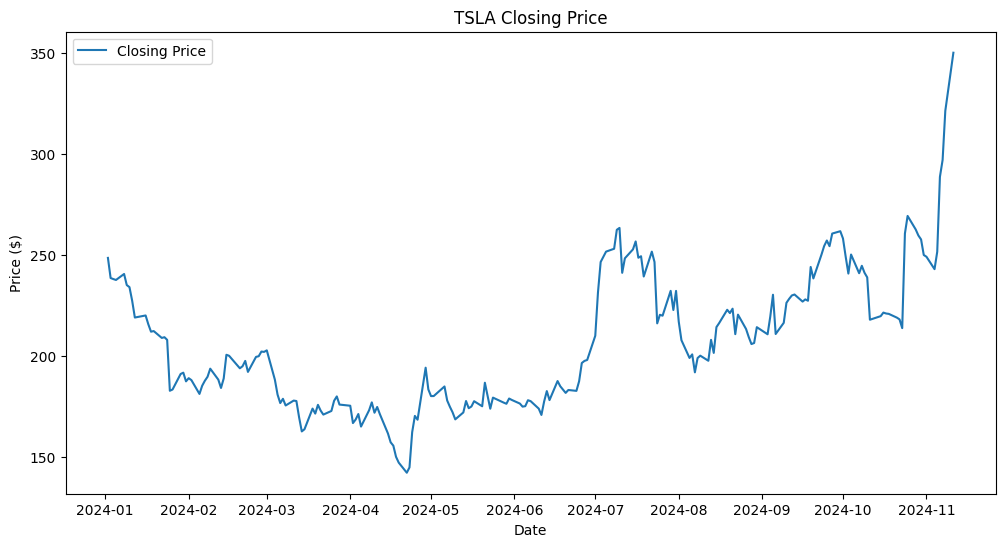

In [753]:
# Plot the closing price with color-coding based on RSI values
plt.figure(figsize=(12, 6))

plt.plot(df['Close'], label='Closing Price')

# Add title, labels, and legend
plt.title(f'{stock_symbol} Closing Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()

# Save the plot in 300dpi
plt.savefig(f'{stock_symbol}_stock_chart.png', dpi=300)

# Show the plot
plt.show()

## Backtest the Momentum Strategy

### Calculate the short and long EWMA

In [754]:
# Define the parameters for the EWMA and RSI
SHORT_WINDOW = 10
LONG_WINDOW = 50

# Calculate SHORT_WINDOW and LONG_WINDOW EWMAs with dynamic column names
df[f'EWMA_{SHORT_WINDOW}'] = df['Close'].ewm(span=SHORT_WINDOW, adjust=False).mean()  # Short window
df[f'EWMA_{LONG_WINDOW}'] = df['Close'].ewm(span=LONG_WINDOW, adjust=False).mean()  # Long window


#### Visualize the EWMAs

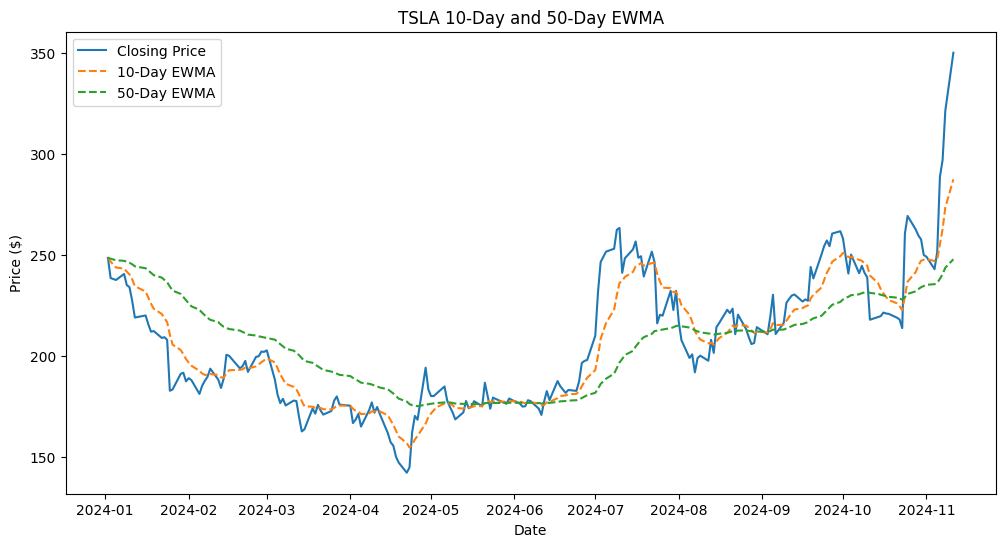

In [755]:
# Plot the closing price, short and long EWMA
plt.figure(figsize=(12, 6))

plt.plot(df['Close'], label='Closing Price')

# Plot EWMA lines
plt.plot(df[f'EWMA_{SHORT_WINDOW}'], label=f'{SHORT_WINDOW}-Day EWMA', linestyle='--')
plt.plot(df[f'EWMA_{LONG_WINDOW}'], label=f'{LONG_WINDOW}-Day EWMA', linestyle='--')

# Add title, labels, and legend
plt.title(f'{stock_symbol} {SHORT_WINDOW}-Day and {LONG_WINDOW}-Day EWMA')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()

# Save the plot in 300 dpi
plt.savefig(f'{stock_symbol}_ewma_plot.png', dpi=300)

# Show the plot
plt.show()


### Calculate the Relative Strength Index (RSI)

In [756]:
# RSI calculation function
def calculate_rsi(data):
    """Calculate the Relative Strength Index (RSI)"""
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=RSI_WINDOW).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=RSI_WINDOW).mean()
    
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

RSI_WINDOW = 14

# Calculate the 14-day RSI
df['RSI'] = calculate_rsi(df['Close'])

#### Visualize the RSI

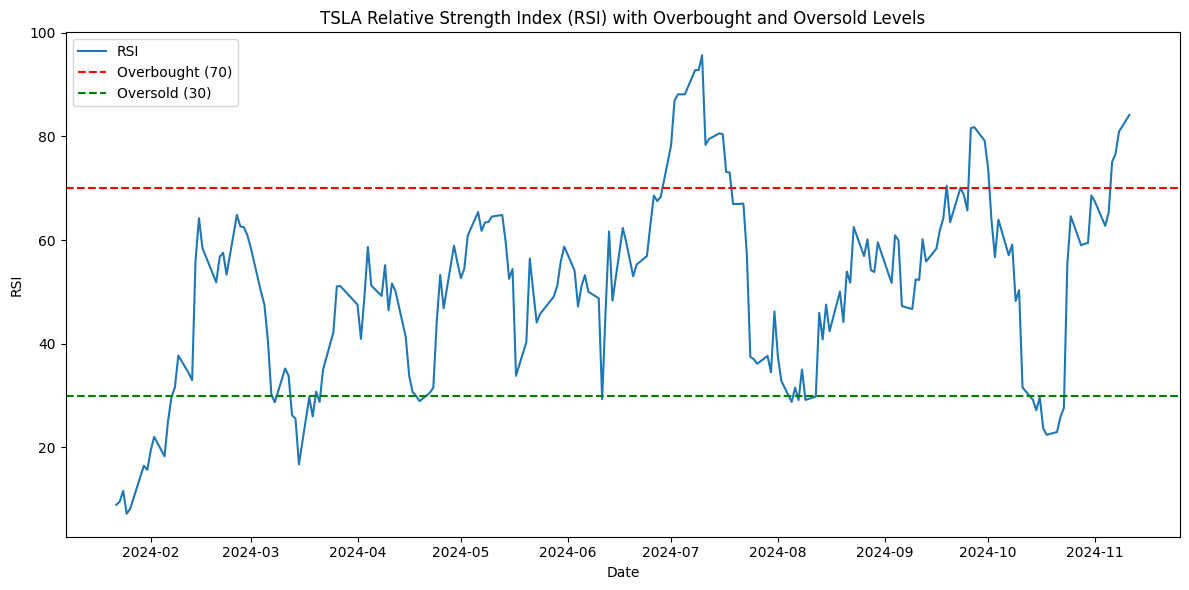

In [757]:
# Plotting the RSI in a separate plot
plt.figure(figsize=(12, 6))

# Plot the RSI line
plt.plot(df['RSI'], label='RSI')

# Add horizontal lines for the overbought and oversold levels
plt.axhline(y=70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(y=30, color='green', linestyle='--', label='Oversold (30)')

# Title and labels
plt.title(f'{stock_symbol} Relative Strength Index (RSI) with Overbought and Oversold Levels')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend(loc='upper left')

# Save the figure in 300dpi
plt.savefig(f'{stock_symbol}_RSI.png', dpi=300)

# Show the plot
plt.tight_layout()
plt.show()


In [758]:
df.tail()

Price,Open,Close,Volume,Low,High,EWMA_10,EWMA_50,RSI
Date,,,,,,,,
2024-11-05 00:00:00+00:00,247.339996,251.440002,69282500,246.210007,255.279999,247.715756,236.028079,65.335638
2024-11-06 00:00:00+00:00,284.670013,288.529999,165228700,275.619995,289.589996,255.136527,238.086978,75.085294
2024-11-07 00:00:00+00:00,288.890015,296.910004,117309200,285.519989,299.750000,262.731705,240.393764,76.644988
2024-11-08 00:00:00+00:00,299.140015,321.220001,204782800,297.660004,328.709991,273.365941,243.563420,80.933092
2024-11-11 00:00:00+00:00,346.299988,350.000000,208785500,336.000000,358.640015,287.299406,247.737403,84.139210


### Brokerage Fee

It's essential to include the brokerage fee when backtesting a trading strategy for more realistic returns

In [759]:
# Define the fee calculation function
def calculate_fee(amount: float) -> float:
    """Calculate the brokerage fee based on transaction amount."""
    fee = amount * 0.0025  # 0.25% of the transaction
    return max(fee, 0.01)   # Minimum fee of $0.01

### Generate a buy/sell signal based on the short and long EWMA and the RSI

In [760]:
# Helper function to check if a buy condition is met
def is_buy_signal(i):
    """Check if the buy signal condition is met."""
    short_above_long = df[f'EWMA_{SHORT_WINDOW}'].iloc[i] > df[f'EWMA_{LONG_WINDOW}'].iloc[i]
    short_below_long_prev = df[f'EWMA_{SHORT_WINDOW}'].iloc[i-1] <= df[f'EWMA_{LONG_WINDOW}'].iloc[i-1]
    rsi_below_70 = df['RSI'].iloc[i] < 70
    return short_above_long and short_below_long_prev and rsi_below_70

# Helper function to check if a sell condition is met
def is_sell_signal(i):
    """Check if the sell signal condition is met."""
    short_below_long = df[f'EWMA_{SHORT_WINDOW}'].iloc[i] < df[f'EWMA_{LONG_WINDOW}'].iloc[i]
    short_above_long_prev = df[f'EWMA_{SHORT_WINDOW}'].iloc[i-1] >= df[f'EWMA_{LONG_WINDOW}'].iloc[i-1]
    rsi_above_30 = df['RSI'].iloc[i] > 30
    return short_below_long and short_above_long_prev and rsi_above_30

### Simulate the strategy

In [761]:
# Initialize variables for the simulation
initial_investment = 100
cash = initial_investment
position = 0

buy_signals = []
sell_signals = []
portfolio_values = []

# List to store the tabulated data
table_data = []

# Implement the momentum strategy
for i in range(1, len(df)):
    # Check if buy signal condition is met
    if is_buy_signal(i):
        # Buy only if not already holding
        if position == 0:
            position = cash / df['Close'].iloc[i]
            fee = calculate_fee(position * df['Close'].iloc[i])
            cash -= position * df['Close'].iloc[i] + fee
            buy_signals.append(df.index[i])  # Using 'Date' column for the date
            
            # Record the results for this buy action
            table_data.append([
                df.index[i].strftime('%Y-%m-%d'),      # Date of transaction, formatted to show only the date
                df['Close'].iloc[i],                          # Closing Price
                round(cash + position * df['Close'].iloc[i], 2),        # Net Investment ($)
                round(fee, 2),                                          # Fee ($)
                round(cash + position * df['Close'].iloc[i] + fee, 2),  # Total Investment ($)
                round(position, 2),                                     # Total Shares
                round(cash + position * df['Close'].iloc[i], 2),        # Portfolio Value ($)
                'Buy'                                         # Action (Buy)
            ])
    
    # Check if sell signal condition is met
    elif is_sell_signal(i):
        # Sell only if holding
        if position > 0:
            cash += position * df['Close'].iloc[i]
            fee = calculate_fee(position * df['Close'].iloc[i])
            cash -= fee
            position = 0
            sell_signals.append(df.index[i])  # Using 'Date' column for the date

            # Record the results for this sell action
            table_data.append([
                df.index[i].strftime('%Y-%m-%d'),      # Date of transaction, formatted to show only the date
                df['Close'].iloc[i],                          # Closing Price
                round(cash + position * df['Close'].iloc[i], 2),        # Net Investment ($)
                round(fee, 2),                                          # Fee ($)
                round(cash + position * df['Close'].iloc[i] + fee, 2),  # Total Investment ($)
                round(position, 2),                                     # Total Shares
                round(cash + position * df['Close'].iloc[i], 2),        # Portfolio Value ($)
                'Sell'                                        # Action (Sell)
            ])
    
    # Record portfolio value after each transaction
    portfolio_values.append(cash + position * df['Close'].iloc[i])

# Final portfolio value
final_portfolio_value = cash + position * df['Close'].iloc[-1]

# Add final portfolio value row
table_data.append([
    df.index[-1].strftime('%Y-%m-%d'),        # Date of the final transaction, formatted to show only the date
    df['Close'].iloc[-1],                            # Closing Price of the final transaction
    'Final Portfolio',                                # Label for the final portfolio value row
    '',                                              # No fee for the final row
    '',                                              # No total investment for the final row
    '',                                              # No total shares for the final row
    final_portfolio_value,                           # Final Portfolio Value
    'N/A'                                            # No action for the final portfolio row
])

# Print the final results in a tabular format
headers = ['Date', 'Closing Price', 'Net Investment ($)', 'Fee ($)', 'Total Investment ($)', 'Total Shares', 'Portfolio Value ($)', 'Action']
print(tabulate(table_data, headers=headers, floatfmt=".2f", tablefmt="grid"))


+------------+-----------------+----------------------+-----------+------------------------+----------------+-----------------------+----------+
| Date       |   Closing Price | Net Investment ($)   | Fee ($)   | Total Investment ($)   | Total Shares   |   Portfolio Value ($) | Action   |
+============+=================+======================+===========+========================+================+=======================+==========+
| 2024-05-21 |          186.60 | 99.75                | 0.25      | 100.0                  | 0.54           |                 99.75 | Buy      |
+------------+-----------------+----------------------+-----------+------------------------+----------------+-----------------------+----------+
| 2024-06-05 |          175.00 | 93.3                 | 0.23      | 93.53                  | 0              |                 93.30 | Sell     |
+------------+-----------------+----------------------+-----------+------------------------+----------------+---------------------

#### Visualize the buys and sells superimposed on the chart

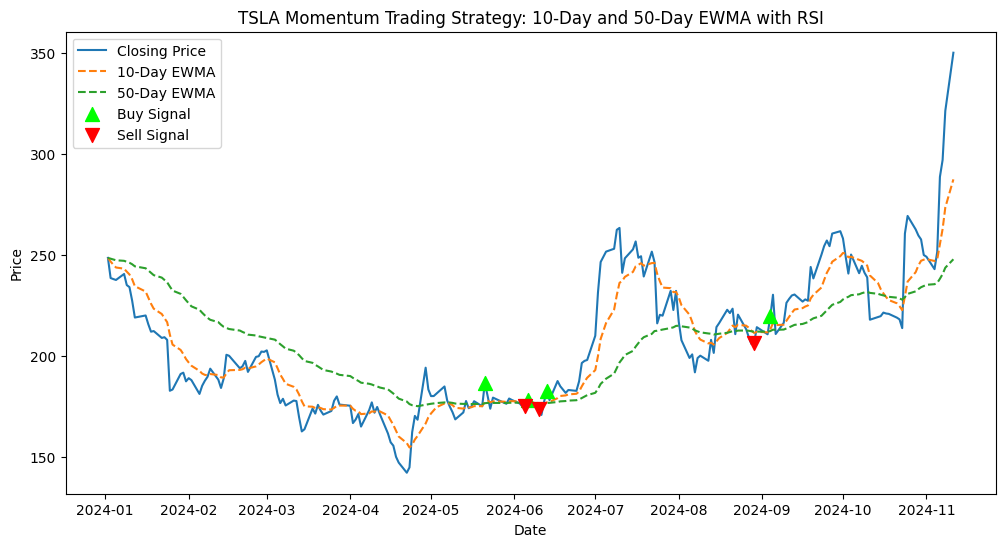

In [762]:
# Plot the closing price with color-coding based on RSI values
plt.figure(figsize=(12, 6))

plt.plot(df['Close'], label='Closing Price')

# Plot EWMA lines
plt.plot(df[f'EWMA_{SHORT_WINDOW}'], label=f'{SHORT_WINDOW}-Day EWMA', linestyle='--')
plt.plot(df[f'EWMA_{LONG_WINDOW}'], label=f'{LONG_WINDOW}-Day EWMA', linestyle='--')

# Plot buy and sell signals as triangles
plt.scatter(buy_signals, df.loc[buy_signals, 'Close'], marker='^', color='lime', label='Buy Signal', s=100, zorder=5)
plt.scatter(sell_signals, df.loc[sell_signals, 'Close'], marker='v', color='red', label='Sell Signal', s=100, zorder=5)

# Add title, labels, and legend
plt.title(f'{stock_symbol} Momentum Trading Strategy: {SHORT_WINDOW}-Day and {LONG_WINDOW}-Day EWMA with RSI')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Plot the figure in 300dpi
plt.savefig(f'{stock_symbol}_momentum_buys_and_sells.png', dpi=300)

# Show the plot
plt.show()
